In [1]:
import matplotlib
import matplotlib.pyplot as plt
import mrlattice.lattice.configure as lcon
import mrlattice.lattice as lat

In [2]:
# this notebook requires mrlattice version:
VERSION = "0.1.2"

In [3]:
%run prepare_notebook.ipynb

The following names are now available:

<class '__main__.LatticeArrayPlotWidget'>


In [4]:
%load_ext jupyter_spaces

In [5]:
# interactive plots in notebook
# %matplotlib notebook
# open external window with plot
# %matplotlib qt
# for saving widget state
%matplotlib inline

if "inline" in matplotlib.get_backend():
    plt.rcParams["figure.figsize"] = (14, 14)
else:
    plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Summary

We show how to fully integrate a new property into LatticeArray and LatticeArrayPlotWidget. We add a dynamic title to the plotted lattice. It contains the values of the properties for the plot and can also be changed to the input from a textbox.

## Note:
The new functionality added in this notebook is not merged with `mrlattice`.

# Adding New Properties

Admittedly, in the last notebook we "cheated" and added new functionality to existing properties. This time around we will integrate a fully new property in both, LatticeArray and LatticeArrayPlotWidget. The intention behind this is to lift the curtain on the internals of LatticeArray and LatticeArrayPlotWidget. Hopefully, this will serve as an explanatory example that conveys a suggested workflow.

The basic steps we need to solve are:
- Add a new LatticeArrayProperty to LatticeArray
- Register it as a property
- For the new property:
    - Update the value setter
    - Update `_check_bounds_and_update()`
- Update `update_properties()` with the new property

### Adding a Dynamic Title to the Plot

Our goal shall be to add a dynamic title to the lattice plot that shows all the properties' and the scheme's values for the plotted configuration. We also shall expand the plot widget to show the current title and edit it if we so desire.


## New LatticeArrayProperty

First we need to create a new property. The existing LatticeArrayProperty is designed for numerical values and therefore cannot be simply used for strings. In the `__init__()` we therefore change the default value of the property to a template string. We also need to update the value setter. Changing the title doesn't have any follow up affects on other properties, so we can drop the call to `lattice.update_properties()`. We also do not need to check any bounds. This leaves us with a very simple setter. Python cannot implicitly deal with inherited properties whose setters we change. We therefore need to include a copy of the getter (property) in our changes. The interesting part lies in `_check_bounds_and_update()`. Here we process how changes of any other property affect our title. We simply create a new title by joining all properties on ", " and add the scheme.

A small note about other methods of LatticeArrayProperty:  
We did not overwrite all methods that are defined for properties (eg. `increment()`). In theory we should do that. However, we trust that using `increment()` on a title (=string) will not happen, as it doesn't make sense.

In [6]:
class LatticeArrayTitleProperty(lcon.LatticeArrayProperty):
    
    def __init__(self, *args, **kwargs):
        # we do not change or add any init args
        super().__init__(*args, **kwargs)
        
        # set a default value, now string
        self._value = "Title"
        # we can delete the other numeric value
        # or set them None for better compatibility with existing methods
        self._min = None
        self._step = None
    
    @property
    def value(self):
        return self._value
    
    @value.setter
    def value(self, other):
        self._value = other
    
    def _check_bounds_and_update(self):
        # build title by joining all props values
        val_string = [
            f"{prop}: {getattr(self._lattice_array, prop).value}"
            for prop in self._lattice_array.PROPERTY_DESCRIPTIONS.keys()
        ] + [f"scheme: {self._lattice_array.scheme.name}"]
        # here we can use the setter, as the setter doesn't call update_properties
        # else we would have to assign to `_value` to prevent recursion loop
        self.value = ", ".join(val_string)

## New LatticeArray

The next step is to update LatticeArray with our new title property. Here we choose not to add the title property to the `PROPERTY_DESCRIPTIONS` dictionary. That dictionary should only be used for LatticeArrayProperties that are tightly integrated. As shown in LatticeArrayTitleProperty, that dict is used to iterate over and get the attributes of LatticeArray that contain LatticeArrayProperties. As the title is a different kind of property, we don't mess with `PROPERTY_DESCRIPTIONS`.

We also have the choice of implementing the title as a real Python property. In the style of the LatticeArrayProperties, this would also lead to a read only attribute of LatticeArray for the title. If we didn't want to do that, we could just skip adding a new property (the getter) and assign the title to the attribute `title` (without leading "\_") directly. Assigning the attribute is done by `__init__` of the property.

For the `__init__` of LatticeArrayTitle we add a new kw argument for setting the title. Then we add the title property. As we did not register the title in `PROPERTY_DESCRIPTIONS`, we can use the constructor of the property to do the work for us. The `description` argument sets the string that will be displayed by the plot widget as the name of the property. Here it is important to first add our title property before calling `__init__` from the superclass, because in that `__init__` a call to `update_properties()` happens. If by the time of that call, the instance didn't have a title property, our new `update_properties()` will error. Then we optionally set the title to the title parameter. Here we used the `.title` property and thus the getter method (and not `._title`).

Lastly, we need to update `update_properties()`. We have two options here. If our title would depend on the active scheme, we would only need to update the two methods `_update_props_fixed_number` and `_update_props_fixed_number` that each perform different actions based on the scheme. But our title does the same things regardless. Therefore, we can update `update_properties()` directly. We append to it the call to `_check_bounds_and_update` and call it a day.

In [7]:
class LatticeArrayTitle(lat.LatticeArray):
    
    def __init__(self, *args, title=None, **kwargs):
                
        _ = LatticeArrayTitleProperty(lattice=self, description="Title of Plot", name="_title")
        
        super().__init__(*args, **kwargs)
        
        if title:
            self.title.value=title
        else:
            # if no title supplied, just generate the default one
            self.title._check_bounds_and_update()
            
    @property
    def title(self):
        return self._title
    
    def update_properties(self):
        super().update_properties()
        self.title._check_bounds_and_update()

## Updating LatticeArrayPlotWidget

We could already work with LatticeArrayTitle, but we wouldn't see anything as we didn't change the plotting routines yet. We need to update `_plot_button_on_click` that controls the plotting. It would also be nice to have a textbox that shows us the current title and allowed us to change it. After adding the textbox as an attribute, we need to first register slider changes to update the title. We therefore update `_slider_callback` to update the title textbox with the value from the LatticeArray. The same is true for the `_scheme_callback`. Lastly we need to propagate input from the textbox back to `LatticeArray.title`. We register a new observe method `_title_callback`.  
There is one catch though. If we edit the title and then change a slider, the title will forget our changes and reset to its auto-generated value.

In [8]:
class LatticeArrayTitlePlotWidget(LatticeArrayPlotWidget):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        self.title_text = widgets.Textarea(
            value=self.lattice.title.value,
            description=self.lattice.title.description,
            layout=widgets.Layout(width='auto'),
        )
        self.title_text.unobserve(self._title_callback, names="value")
        
        new_childs = list(self.children[0].children)
        new_childs.insert(1, self.title_text)
        self.children[0].children = new_childs
    
    def _title_callback(self, change):
        self.lattice.title.value = change["new"]
    
    def _slider_callback(self, change):
        super()._slider_callback(change)
        # unobserve when changes come from lattice
        self.title_text.unobserve(self._title_callback, names="value")
        self.title_text.value = self.lattice.title.value
        self.title_text.observe(self._title_callback, names="value")
    
    def _scheme_callback(self, change):
        super()._scheme_callback(change)
        self.title_text.value = self.lattice.title.value
    
    def _plot_button_on_click(self, *args):
        super()._plot_button_on_click(*args)
        # add title to figure
        self.fig_out.gca().set_title(self.lattice.title.value, size="small")

LatticeArrayTitlePlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Bord…

Output()

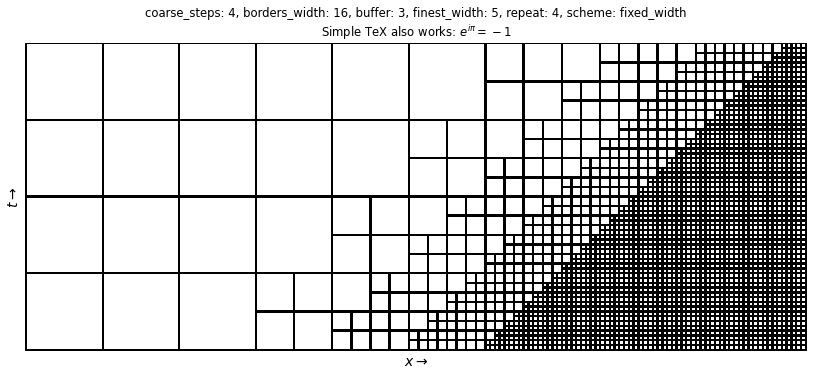

In [9]:
LatticeArrayTitlePlotWidget(lattice=LatticeArrayTitle())

LatticeArrayTitlePlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Bord…

Output()

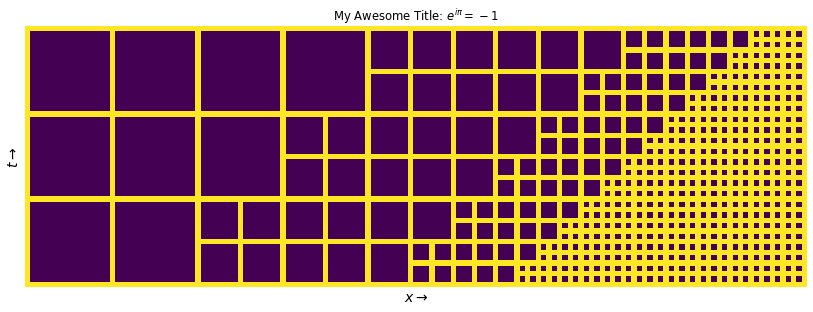

In [10]:
init_param_dict = {
    "scheme": "fixed_number",
    "coarse_steps": 3,
    "borders_width": 5,
    "buffer": 2,
    "finest_width": 5,
    "repeat": 3,
}
LatticeArrayTitlePlotWidget(
    lattice=LatticeArrayTitle(
        title=r"My Awesome Title: $e^{i\pi}=-1$", **init_param_dict
    )
)